<a href="https://colab.research.google.com/github/LanxyL/Capstone3---Recommendation-System/blob/main/Notebook/Recommendation_System_on_Amazon_home_kitchen_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error

In [3]:
#Read Kitchen&Dining Dataset from last notebook
KitchenDining = pd.read_csv('drive/My Drive/Recommendation_System/KitchenDining80000.csv')

In [4]:
# transform the ratings frame into a ratings matrix
ratings_mtx_df = KitchenDining.pivot_table(values='overall',
                                           index='reviewerID',
                                           columns='asin')
ratings_mtx_df.head(3)

asin,0912696591,B00000JGRP,B00000JGRQ,B00000JGRT,B00002N602,B00004OCIP,B00004OCIQ,B00004OCIU,B00004OCIX,B00004OCIZ,B00004OCJ6,B00004OCJ9,B00004OCJJ,B00004OCJK,B00004OCJN,B00004OCJO,B00004OCJQ,B00004OCJW,B00004OCK0,B00004OCK3,B00004OCKO,B00004OCKR,B00004OCKT,B00004OCL2,B00004OCL8,B00004OCL9,B00004OCLA,B00004OCLK,B00004OCLW,B00004OCM4,B00004OCMB,B00004OCMM,B00004OCMS,B00004OCMX,B00004OCMY,B00004OCNE,B00004OCNJ,B00004OCNK,B00004OCNL,B00004OCNQ,...,B00JW02L9W,B00JWXSPAS,B00JWY1PPE,B00JWYX7YQ,B00JWZCE08,B00JZKZPMO,B00JZL11V2,B00JZXYG9O,B00K11U0Y4,B00K4S1L1K,B00K4V4EWA,B00K6BCV7S,B00K7ILPYU,B00K7P0D9G,B00K8LHA3G,B00KAF5DLQ,B00KAJ3OY0,B00KAK443Y,B00KB7KNRM,B00KBQ1OHQ,B00KBUGQJS,B00KCFDB4U,B00KD83BMS,B00KDV5RZY,B00KFS40N0,B00KI2RQHU,B00KIVD1PC,B00KKYSBUW,B00KM9W2PU,B00KNPVL8W,B00KQCJ0CG,B00KQXDIG4,B00KSRQN0Q,B00KSRSZC0,B00KSRV3UQ,B00KSRXUC0,B00KW1ZDCM,B00KWKQ2MS,B00L8FQZ3M,B00LB18EKK
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00593903MCE5GXTAGGNL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A037357115LCU92V2R0YR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(KitchenDining, test_size=0.2, random_state=42)

In [6]:
print(train.shape)
print(test.shape)
print(KitchenDining.shape)

(65558, 24)
(16390, 24)
(81948, 24)


In [7]:
# transform the train ratings frame into a ratings matrix
train_sparse = train.pivot_table(values='overall',
                                 index='reviewerID',
                                 columns='asin')
train_sparse.head(3)

asin,0912696591,B00000JGRP,B00000JGRQ,B00000JGRT,B00002N602,B00004OCIP,B00004OCIQ,B00004OCIU,B00004OCIX,B00004OCIZ,B00004OCJ6,B00004OCJ9,B00004OCJJ,B00004OCJK,B00004OCJN,B00004OCJO,B00004OCJQ,B00004OCJW,B00004OCK0,B00004OCK3,B00004OCKO,B00004OCKR,B00004OCKT,B00004OCL2,B00004OCL8,B00004OCL9,B00004OCLA,B00004OCLK,B00004OCLW,B00004OCM4,B00004OCMB,B00004OCMM,B00004OCMS,B00004OCMX,B00004OCMY,B00004OCNE,B00004OCNJ,B00004OCNK,B00004OCNL,B00004OCNQ,...,B00JW02L9W,B00JWXSPAS,B00JWY1PPE,B00JWYX7YQ,B00JWZCE08,B00JZKZPMO,B00JZL11V2,B00JZXYG9O,B00K11U0Y4,B00K4S1L1K,B00K4V4EWA,B00K6BCV7S,B00K7ILPYU,B00K7P0D9G,B00K8LHA3G,B00KAF5DLQ,B00KAJ3OY0,B00KAK443Y,B00KB7KNRM,B00KBQ1OHQ,B00KBUGQJS,B00KCFDB4U,B00KD83BMS,B00KDV5RZY,B00KFS40N0,B00KI2RQHU,B00KIVD1PC,B00KKYSBUW,B00KM9W2PU,B00KNPVL8W,B00KQCJ0CG,B00KQXDIG4,B00KSRQN0Q,B00KSRSZC0,B00KSRV3UQ,B00KSRXUC0,B00KW1ZDCM,B00KWKQ2MS,B00L8FQZ3M,B00LB18EKK
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00593903MCE5GXTAGGNL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A037357115LCU92V2R0YR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# transform the test ratings frame into a ratings matrix
test_sparse = test.pivot_table(values='overall',
                               index='reviewerID',
                               columns='asin')
test_sparse.head(3)

asin,0912696591,B00000JGRQ,B00000JGRT,B00002N602,B00004OCIP,B00004OCIQ,B00004OCIU,B00004OCIX,B00004OCIZ,B00004OCJ6,B00004OCJ9,B00004OCJJ,B00004OCJK,B00004OCJN,B00004OCJO,B00004OCJQ,B00004OCJW,B00004OCK0,B00004OCK3,B00004OCKO,B00004OCKR,B00004OCKT,B00004OCL2,B00004OCL8,B00004OCL9,B00004OCLA,B00004OCLK,B00004OCLW,B00004OCM4,B00004OCMB,B00004OCMM,B00004OCMS,B00004OCMX,B00004OCMY,B00004OCNE,B00004OCNJ,B00004OCNK,B00004OCNL,B00004OCNQ,B00004OCNS,...,B00JS3O3J4,B00JS70WFY,B00JW02L9W,B00JWXSPAS,B00JWY1PPE,B00JWYX7YQ,B00JWZCE08,B00JZKZPMO,B00JZL11V2,B00JZXYG9O,B00K11U0Y4,B00K4S1L1K,B00K4V4EWA,B00K6BCV7S,B00K7ILPYU,B00K7P0D9G,B00K8LHA3G,B00KAF5DLQ,B00KAK443Y,B00KB7KNRM,B00KBQ1OHQ,B00KBUGQJS,B00KCFDB4U,B00KD83BMS,B00KDV5RZY,B00KFS40N0,B00KI2RQHU,B00KIVD1PC,B00KKYSBUW,B00KM9W2PU,B00KNPVL8W,B00KQXDIG4,B00KSRQN0Q,B00KSRSZC0,B00KSRV3UQ,B00KSRXUC0,B00KW1ZDCM,B00KWKQ2MS,B00L8FQZ3M,B00LB18EKK
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00593903MCE5GXTAGGNL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A037357115LCU92V2R0YR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Finding Global Average of all item ratings from sampled train dataset
print("Global average of all products raview ratings in Train Sample is {}".format(np.round(train.overall.mean(), 2)))

Global average of all products raview ratings in Train Sample is 4.41


In [10]:
print("Sparsity Of Train matrix : {}% ".format((train_sparse.isna().sum().sum()/(train_sparse.shape[1]*train_sparse.shape[0])*100)))

Sparsity Of Train matrix : 99.8040639734504% 


In [11]:
print("Sparsity Of Test matrix : {}% ".format((test_sparse.isna().sum().sum()/(test_sparse.shape[1]*test_sparse.shape[0])*100)))

Sparsity Of Test matrix : 99.93096402193584% 


In [12]:
def getAverageUserRatings(df, userid):
    return df.loc[userid, :].mean()

In [13]:
def getAverageItemRatings(df, itemid):
    return df.loc[:, itemid].mean()

In [14]:
def num_users_rate(df, itemid):
  return df.loc[:, itemid].count()

In [15]:
def num_items_rate(df, userid):
  return df.loc[userid, :].count()

In [16]:
train_surprice = train[['reviewerID', 'asin', 'overall', 'price', 'year', 'month', 'reviewlength']]
train_surprice = train_surprice.dropna()
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength
1276,A1IT7KPZW9DY05,B00004OCMY,5.0,10.87,2006,9,153
48696,A3DQ4FF1IW84EC,B0026K0XEU,5.0,19.99,2012,1,59
33288,A9KAY47NCPQS,B000KIHMR6,5.0,12.99,2009,8,82
28056,A2UR34OLZP2MUV,B000EGA6QI,5.0,29.95,2010,9,99
251,AVR3F6VQYIMZW,B00004OCIP,5.0,8.80,2005,10,137


In [17]:
train_surprice['user_avg'] = train_surprice['reviewerID'].apply(lambda x: getAverageUserRatings(ratings_mtx_df, x))

In [18]:
train_surprice['item_avg'] = train_surprice['asin'].apply(lambda x: getAverageItemRatings(ratings_mtx_df, x))

In [19]:
#Obtain how many users rate each item
train_surprice['num_users_rate'] = train_surprice['asin'].apply(lambda x: num_users_rate(ratings_mtx_df, x))

In [20]:
#Obtain how many items each user rated
train_surprice['num_items_rate'] = train_surprice['reviewerID'].apply(lambda x: num_items_rate(ratings_mtx_df, x))

In [21]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate
1276,A1IT7KPZW9DY05,B00004OCMY,5.0,10.87,2006,9,153,5.000000,4.750000,32,9
48696,A3DQ4FF1IW84EC,B0026K0XEU,5.0,19.99,2012,1,59,4.947368,4.750000,12,19
33288,A9KAY47NCPQS,B000KIHMR6,5.0,12.99,2009,8,82,3.806452,4.083333,12,31
28056,A2UR34OLZP2MUV,B000EGA6QI,5.0,29.95,2010,9,99,3.750000,4.503937,127,8
251,AVR3F6VQYIMZW,B00004OCIP,5.0,8.80,2005,10,137,4.714286,4.619048,63,14


In [22]:
test_surprice = test[['reviewerID', 'asin', 'overall', 'price', 'year', 'month', 'reviewlength']]
test_surprice = test_surprice.dropna()
test_surprice['user_avg'] = test_surprice['reviewerID'].apply(lambda x: getAverageUserRatings(ratings_mtx_df, x))
test_surprice['item_avg'] = test_surprice['asin'].apply(lambda x: getAverageItemRatings(ratings_mtx_df, x))
test_surprice['num_users_rate'] = test_surprice['asin'].apply(lambda x: num_users_rate(ratings_mtx_df, x))
test_surprice['num_items_rate'] = test_surprice['reviewerID'].apply(lambda x: num_items_rate(ratings_mtx_df, x))

In [23]:
def evaluate(estimate_f):
  """ RMSE-based predictive performance evaluation with pandas. """
  ids_to_estimate = zip(test.reviewerID, test.asin) 
  estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
  real = test.overall.values
  return np.sqrt(mean_squared_error(real, estimated))

In [24]:
#Predict all reviews as 5 star and see how accurate it would be
def simple_estimate_function(user_id, item_id): return 5

In [25]:
print('RMSE for simple estimate function: %s' % evaluate(simple_estimate_function))

RMSE for simple estimate function: 1.1679051504777722


Since we already know that most of the people rate 5 on the review. Let us set this estimation function as a threshold. A better model shall have a much smaller RMSE.

In [26]:
def content_mean(user_id, item_id):
  """ Simple content-filtering based on mean ratings. """
  if user_id in train.reviewerID.to_list():
    user_condition = train.reviewerID == user_id
    return train.loc[user_condition, 'overall'].mean()
  else:
    return 5
print('RMSE for content mean estimation: %s' % evaluate(content_mean))

RMSE for content mean estimation: 1.0163738085650693


In [27]:
def collaborative_mean(user_id, item_id):
  """ Simple collaborative-filtering based on mean ratings. """
  if item_id in train.asin.to_list():
    item_condition = train.asin == item_id
    return train.loc[item_condition, 'overall'].mean()
  else:
    return 5
print('RMSE for collaborative mean estimation: %s' % evaluate(collaborative_mean))

RMSE for collaborative mean estimation: 0.9800639711532739


In [28]:
KitchenDining.head()

,Unnamed: 0,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,salesRank,title,description,related,price,brand,year,month,reviewlength,mainCategory,subCategory1,subCategory2,subCategory3,subCategory4,subCategory5,subCategory6#
0,315,A39RRTO760KGOY,0912696591,"[0, 0]","had no idea about decorating cakes,by this boo...",5.0,follow the instructions,2012-05-27,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2012,5,56,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN
1,317,AZF13R8HNB59E,0912696591,"[0, 1]","excellent book, shipped on time, packaged nice...",5.0,book,2012-06-12,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2012,6,24,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN
2,318,A1KCBA3PKLV2IT,0912696591,"[0, 0]",i loved it. don't use it much but when i had i...,5.0,great!,2012-12-26,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2012,12,27,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN
3,321,A3JM7FVJMPJ1XD,0912696591,"[4, 4]",So I actually bought this thinking it was the ...,3.0,Good for what it's worth,2012-08-16,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2012,8,92,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN
4,326,A1B9BZ3AJ5V1NJ,0912696591,"[0, 0]",I'm hoping that I can learn how to make gum pa...,5.0,learning,2014-05-21,{'Kitchen & Dining': 9690},Wilton Decorating Cakes Book,This exciting book presents what Wilton has l...,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '...",14.26,Wilton,2014,5,24,Home & Kitchen,Kitchen & Dining,Bakeware,Baking & Cookie Sheets,NaN,NaN,NaN


In [29]:
import json
product_related = []
for i in range(KitchenDining.shape[0]):
  product_related.append([KitchenDining.asin[i],KitchenDining.related[i]])
product_related = pd.DataFrame(product_related)
product_related = product_related.rename(columns={0:'asin', 1:'related'})
product_related.dropna(inplace=True)
product_related.drop_duplicates(inplace=True)
product_related.reset_index()
product_related.head()

,asin,related
0,0912696591,"{'also_bought': ['B003MC22TU', 'B003MC22PY', '..."
41,B00000JGRP,"{'also_viewed': ['B0000645YL', 'B0000645YM', '..."
68,B00000JGRQ,"{'also_bought': ['B00004S9CJ', 'B001D9B2R2', '..."
80,B00000JGRT,"{'also_bought': ['B00004S9D3', '0894803123', '..."
152,B00002N602,"{'also_bought': ['B000ORD8GM', '0965410803', '..."


In [30]:
product_related.shape

(3320, 2)

In [31]:
relation_dict = dict()
for i in product_related.index:
  x=product_related.related[i]
  x = str(x).replace("\'", "\"")
  dictx = json.loads(x)
  relation_dict[product_related.asin[i]] = dictx


In [32]:
product_related = pd.DataFrame(relation_dict)

In [33]:
product_related

,0912696591,B00000JGRP,B00000JGRQ,B00000JGRT,B00002N602,B00004OCIP,B00004OCIQ,B00004OCIU,B00004OCIX,B00004OCIZ,B00004OCJ6,B00004OCJ9,B00004OCJJ,B00004OCJK,B00004OCJN,B00004OCJO,B00004OCJQ,B00004OCJW,B00004OCK0,B00004OCK3,B00004OCKO,B00004OCKR,B00004OCKT,B00004OCL2,B00004OCL8,B00004OCL9,B00004OCLA,B00004OCLK,B00004OCLW,B00004OCM4,B00004OCMB,B00004OCMM,B00004OCMS,B00004OCMX,B00004OCMY,B00004OCNE,B00004OCNJ,B00004OCNK,B00004OCNL,B00004OCNQ,...,B00JW02L9W,B00JWXSPAS,B00JWY1PPE,B00JWYX7YQ,B00JWZCE08,B00JZKZPMO,B00JZL11V2,B00JZXYG9O,B00K11U0Y4,B00K4S1L1K,B00K4V4EWA,B00K6BCV7S,B00K7ILPYU,B00K7P0D9G,B00K8LHA3G,B00KAF5DLQ,B00KAJ3OY0,B00KAK443Y,B00KB7KNRM,B00KBQ1OHQ,B00KBUGQJS,B00KCFDB4U,B00KD83BMS,B00KDV5RZY,B00KFS40N0,B00KI2RQHU,B00KIVD1PC,B00KKYSBUW,B00KM9W2PU,B00KNPVL8W,B00KQCJ0CG,B00KQXDIG4,B00KSRQN0Q,B00KSRSZC0,B00KSRV3UQ,B00KSRXUC0,B00KW1ZDCM,B00KWKQ2MS,B00L8FQZ3M,B00LB18EKK
also_bought,"[B003MC22TU, B003MC22PY, B006UKNSVC, B003MC22Z...",NaN,"[B00004S9CJ, B001D9B2R2, B000TQEDDK, B00005QFK...","[B00004S9D3, 0894803123, 149484205X, 158008219...","[B000ORD8GM, 0965410803, 0764597264, B0000Z6JI...","[B000SSTV8Q, B0071OUJDQ, B00004OCO8, B0001YH1A...","[B00004OCM4, B007WTGR90, B000SOAT0Y, B002XOHZW...","[B00004OCIP, B000Q9CIYG, B0000DAQ93, B000VQOP5...",NaN,"[B00004OCLJ, B00004OCL2, B003M8GMS6, B00004OCL...","[B000A13OEI, B001BB2LMM, B0011EZ7AC, B000A13OE...","[B00421ATIQ, B000FUO3QM, B002CZOSL8, B0037XIZD...","[B00004OCJK, B00004OCIP, B004VLYQGS, B000YDO2M...","[B00004OCIP, B00004OCNS, B00004OCJJ, B0000CDVD...","[B003BEDQL2, B0000E1FDA, B0000D8CAO, B00004OCI...","[B0000DAQ93, B0036X4YOG, B00B6LUAPW, B003AIKP0...","[B0019R7SPS, B00004OCNJ, B007L5ROZQ, B000I0MGK...","[B00004OCIP, B00006IFN8, B00004OCJG, B0001YH1A...","[B0000CDVD8, B0001BMXIU, B00004OCMX, B003L0OYJ...","[B0002YTG5Y, B0002YTG4K, B0002YTG3G, B0007P4J3...","[B0007VO0EE, B0001YH1A2, B001713L5C, B00004OCI...","[B002MQ3SOA, B002DWA6K2, B000OUY2QO, B003L0OOR...","[B000AREB5S, B0088LR592, B002XOHZWC, B007WTGR9...","[B00004OCIZ, B00004OCLJ, B001CRC54O, B001OHV29...","[B00004OCOP, B000KEYD9K, B00004OCOQ, B00004OCO...","[B00004OCNS, B00004OCJK, B0045EPNBI, B00004OCI...","[B007U256D2, B0042FN98Y, B0010L1C28, B0038JE5Y...","[B002HMBVKW, B00004OCIZ, B00004OCLJ, B000FEDCN...","[B001713L84, B00KY4Z1I8, B001CDLKHQ, B00004OCN...","[B00CPNUY7Y, B002XOHZWC, B00004OCIQ, B00095VK7...","[B00004OCMX, B000EURKG8, B0069KDUXO, B00004OCM...","[B0001YH1A2, B00004OCIP, B0000DAQ46, B0007VO0C...","[B00004OCMT, B00004OCME, B00004OCMW, B00004OCM...","[B00004OCMB, B00004OCMP, B0001BMXIU, B00004OCM...","[B001CDP5VS, B000M8YMEU, B00004OCO6, B00004OCO...","[B000QJGRJ8, B007638GOQ, B00A2KDAJQ, B0006Z16R...","[B000QJE48O, B000IYYFIQ, B000KEUKO2, B000JPSI8...","[B000VWECPQ, B000MMRNPG, B00004OCNJ, B000QJE48...","[B000QJE48O, B00004OCNJ, B00005OAXZ, B00004OCN...","[B00004OCNS, B00004OCNT, B00004OCO8, B000JPSI8...",...,"[B00JJOEV9Y, B00M04HZIO, B00L8FDIZU, B00L8FQZ3...","[B00JWYX7YQ, B00JJOEV9Y, B00LGVUUA2, B00L8HA5L...","[B00JJOEV9Y, B00LGVUUA2, B00M04HZIO, B00L8HA5L...","[B00JJOEV9Y, B00JWXSPAS, B00LGVUUA2, B00M04HZI...","[B00JJOEV9Y, B00L8FDIZU, B00L8FQZ3M, B00LGVUUA...","[B00J4FUCAA, B00K8LHA3G, B00HDABAQS, B0000CFOI...","[B00JVOIW3S, B00J93MQ6U, B00DDMILGM, B001OAKME...","[B00JJOEV9Y, B00M04HZIO, B00LGVUUA2, B00L8FDIZ...","[B00D19SSE2, B005TA1IUW, B0041ENPEO, B00D1AXYA...","[B00JJOEV9Y, B00L9KOZBK, B00M04HZIO, B00LSXYC6...","[B00JS0TIVK, B00I3LDJJW, B005OLJEZC, B000QIU7X...","[B00K6BCW5O, B00KNPVL8W, B004ZEMSCK, B00DOL3LW...","[B00KZNOHTW, B00KQBR9FM, B00KQVTX06, B00KHGIK5...","[B00KCFDB4U, B00K8LHA3G, B00JVOIW3S, B00KWXBZP...","[B00K7P0D9G, B00KCFDB4U, B00JZKZPMO, B00JVOIW3...","[B00006IV0U, B003GSKQAW, B006OK7RRO, B00GOPICN...",NaN,NaN,NaN,"[B00K7P0D9G, B00KCFDB4U, B001T4URXG, B0052456U...",NaN,"[B00K7P0D9G, B00EZQ8OXU, B00KL1JZEU, B00KTV6DY...","[B00J4FUCAA, B00J3M78GA, B00KDV5RZY, B00HDABAQ...","[B00J4FUCAA, B00J3M78GA, B00KDUYU30, B00HDABAQ...","[B00JJOEV9Y, B00M04HZIO, B00KWP8ZIM, B00KVE7R0...","[B00JJ

In [34]:
def get_mean_rating(items):
  if train['asin'].isin(items).sum() != 0:
    return train[train['asin'].isin(items)].overall.mean()
  else:
    return 0

In [35]:
def collaborative_related(user_id, item_id):
  """ collaborative-filtering based on mean ratings of related products. """
  if item_id in train.asin.to_list():
    item_condition = train.asin == item_id
    if item_id in product_related.columns:
      related_items_bought = product_related.loc['also_bought', item_id]
      if type(related_items_bought) is list:
        mean_rate = get_mean_rating(related_items_bought)
        if mean_rate == 0:
          return train.loc[item_condition, 'overall'].mean()
        else:
          return mean_rate*0.5+train.loc[item_condition, 'overall'].mean()*0.5
      else:
        return train.loc[item_condition, 'overall'].mean()
    else:
      return train.loc[item_condition, 'overall'].mean()
  else:
    return 5
print('RMSE for collaborative related mean estimation: %s' % evaluate(collaborative_related))

RMSE for collaborative related mean estimation: 0.9723112537322619


In [36]:
def get_related_products_rating(item_id):
  if item_id in product_related.columns:
    related_items_bought = product_related.loc['also_bought', item_id]
    if type(related_items_bought) is list:
        mean_rate = get_mean_rating(related_items_bought)
        if mean_rate == 0:
          return getAverageItemRatings(train_sparse, item_id)
        else:
          return mean_rate
    else:
      return getAverageItemRatings(train_sparse, item_id)
  else: return getAverageItemRatings(train_sparse, item_id)

In [37]:
train_surprice['related_rate'] = train_surprice['asin'].apply(lambda x: get_related_products_rating(x))

In [38]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate
1276,A1IT7KPZW9DY05,B00004OCMY,5.0,10.87,2006,9,153,5.000000,4.750000,32,9,4.533672
48696,A3DQ4FF1IW84EC,B0026K0XEU,5.0,19.99,2012,1,59,4.947368,4.750000,12,19,4.576923
33288,A9KAY47NCPQS,B000KIHMR6,5.0,12.99,2009,8,82,3.806452,4.083333,12,31,4.305085
28056,A2UR34OLZP2MUV,B000EGA6QI,5.0,29.95,2010,9,99,3.750000,4.503937,127,8,4.623487
251,AVR3F6VQYIMZW,B00004OCIP,5.0,8.80,2005,10,137,4.714286,4.619048,63,14,4.562676


In [39]:
test_surprice['related_rate'] = test_surprice['asin'].apply(lambda x: get_related_products_rating(x))

##Model with Surprise library

In [40]:
!pip install surprise

In [41]:
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [42]:
train[['reviewerID', 'asin', 'overall']].head(5)

,reviewerID,asin,overall
1276,A1IT7KPZW9DY05,B00004OCMY,5.0
48696,A3DQ4FF1IW84EC,B0026K0XEU,5.0
33288,A9KAY47NCPQS,B000KIHMR6,5.0
28056,A2UR34OLZP2MUV,B000EGA6QI,5.0
251,AVR3F6VQYIMZW,B00004OCIP,5.0


In [43]:
train = train[train['price'].notna()]

In [44]:
test = test[test['price'].notna()]

In [45]:
#Transforming train data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[train['price'].notna()][['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

In [46]:
#Transforming test data
testset = list(zip(test["reviewerID"].values, test["asin"].values, test["overall"].values))

In [47]:
testset[:5]

[('A37CENQP0ZNKVE', 'B00008I8NS', 4.0),
 ('A3IR834T7AROBT', 'B001ULC93O', 4.0),
 ('A2IZ9ZSFBW7JX8', 'B000139H7I', 5.0),
 ('A2NH4IUAHG81G4', 'B004J6EL56', 5.0),
 ('A2J557IQKW3GCP', 'B0093JWH9Q', 5.0)]

In [48]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAE", "Test RMSE", "Test MAE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [49]:
def make_table(model_name, rmse_train, mae_train, rmse_test, mae_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mae_train, rmse_test, mae_test]], columns = ["Model", "Train RMSE", "Train MAE", "Test RMSE", "Test MAE"]))
    error_table.reset_index(drop = True, inplace = True)

In [50]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

In [51]:
import xgboost as xgb
from datetime import datetime
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mae_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAE = {}".format(mae_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAE": mae_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mae_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAE = {}".format(mae_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAE": mae_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mae_train, rmse_test, mae_test)
    
    return train_result, test_result, clf

In [52]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

In [53]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [54]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

In [55]:
def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mae = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAE = {}".format(train_mae))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAE": train_mae, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mae = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAE = {}".format(test_mae))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAE": test_mae, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mae, test_rmse, test_mae)
    
    return train, test

### XGBoost

[00:08:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.7991547721570128
MAE = 0.537532665008567
--------------------------------------------------
TEST DATA
RMSE = 0.7954745361320125
MAE = 0.5374348481119092
--------------------------------------------------
Time Taken = 0:00:03.131561


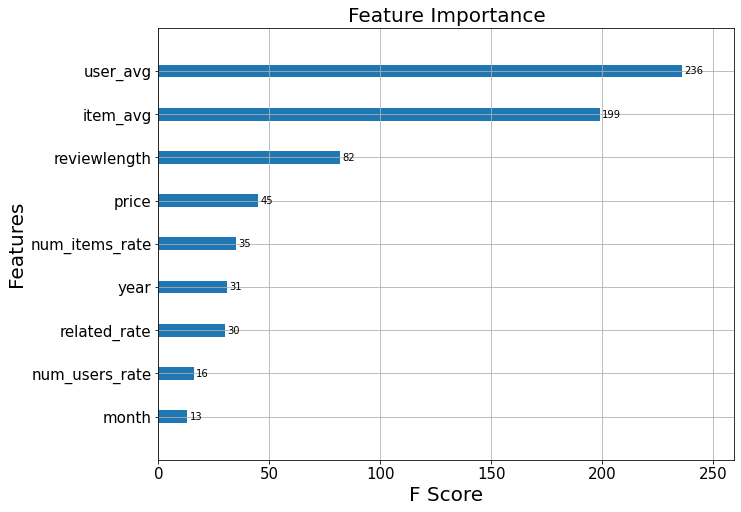

In [56]:
x_train = train_surprice.drop(["reviewerID", "asin", "overall"], axis = 1)

x_test = test_surprice.drop(["reviewerID", "asin", "overall"], axis = 1)

y_train = train_surprice["overall"]

y_test = test_surprice["overall"]

train_result, test_result, XGBclf = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

### Surprise BaselineOnly Model

In [57]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)
#You can check the docs of above used functions at:https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8012177311422825
MAE = 0.5554410741369145
--------------------------------------------------
TEST DATA
RMSE = 0.9366375834964287
MAE = 0.6501908955339114
--------------------------------------------------
Time Taken = 0:00:01.565818


### XGBoost + Suprise BaselineOnly Model

In [58]:
train_surprice['BaselineOnly'] = model_train_evaluation['BaselineOnly']['Prediction']

In [59]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate,BaselineOnly
1276,A1IT7KPZW9DY05,B00004OCMY,5.0,10.87,2006,9,153,5.000000,4.750000,32,9,4.533672,5.000000
48696,A3DQ4FF1IW84EC,B0026K0XEU,5.0,19.99,2012,1,59,4.947368,4.750000,12,19,4.576923,4.620016
33288,A9KAY47NCPQS,B000KIHMR6,5.0,12.99,2009,8,82,3.806452,4.083333,12,31,4.305085,4.867523
28056,A2UR34OLZP2MUV,B000EGA6QI,5.0,29.95,2010,9,99,3.750000,4.503937,127,8,4.623487,4.721608
251,AVR3F6VQYIMZW,B00004OCIP,5.0,8.80,2005,10,137,4.714286,4.619048,63,14,4.562676,4.827175


In [60]:
test_surprice['BaselineOnly'] = model_test_evaluation['BaselineOnly']['Prediction']

[00:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.7990225782735888
MAE = 0.5377795988531189
--------------------------------------------------
TEST DATA
RMSE = 0.7968386091664711
MAE = 0.538226185979431
--------------------------------------------------
Time Taken = 0:00:03.304036


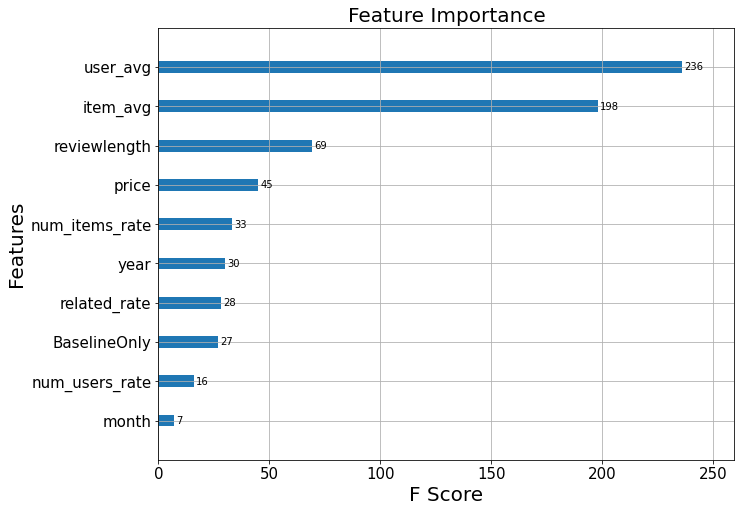

In [61]:
x_train = train_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

x_test = test_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

y_train = train_surprice.dropna().overall

y_test = test_surprice.dropna().overall

train_result, test_result, XGBBSLclf = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

### Surprise KNN-Baseline with User-User.

In [62]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [63]:
sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.014900585039772358
MAE = 0.00485091615057491
--------------------------------------------------
TEST DATA
RMSE = 0.957135144979215
MAE = 0.6726938043894891
--------------------------------------------------
Time Taken = 0:00:10.901525


### Surprise KNN-Baseline with Item-Item

In [64]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [65]:
sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.014039486318089189
MAE = 0.00447250730540295
--------------------------------------------------
TEST DATA
RMSE = 0.9659138597228574
MAE = 0.6712470801863051
--------------------------------------------------
Time Taken = 0:00:03.408842


### XGBoost 13 Features + Surprise BaselineOnly + Surprice KNN Baseline

In [66]:
train_surprice["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
train_surprice["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

test_surprice["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
test_surprice["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [67]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
1276,A1IT7KPZW9DY05,B00004OCMY,5.0,10.87,2006,9,153,5.000000,4.750000,32,9,4.533672,5.000000,5.0,5.000000
48696,A3DQ4FF1IW84EC,B0026K0XEU,5.0,19.99,2012,1,59,4.947368,4.750000,12,19,4.576923,4.620016,5.0,4.996793
33288,A9KAY47NCPQS,B000KIHMR6,5.0,12.99,2009,8,82,3.806452,4.083333,12,31,4.305085,4.867523,5.0,5.000000
28056,A2UR34OLZP2MUV,B000EGA6QI,5.0,29.95,2010,9,99,3.750000,4.503937,127,8,4.623487,4.721608,5.0,5.000000
251,AVR3F6VQYIMZW,B00004OCIP,5.0,8.80,2005,10,137,4.714286,4.619048,63,14,4.562676,4.827175,5.0,5.000000


In [68]:
test_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
12172,A37CENQP0ZNKVE,B00008I8NS,4.0,49.08,2012,8,740,4.416667,2.076923,13,12,4.533333,2.059408,2.780654,2.780654
47840,A3IR834T7AROBT,B001ULC93O,4.0,5.64,2013,10,82,4.625000,3.876923,65,40,4.386228,4.196898,4.166180,4.166180
18709,A2IZ9ZSFBW7JX8,B000139H7I,5.0,39.95,2012,10,311,4.533333,4.750000,12,15,4.628571,4.747486,4.635201,4.635201
60704,A2NH4IUAHG81G4,B004J6EL56,5.0,62.00,2012,1,97,5.000000,4.307692,26,4,4.200000,4.572336,4.416502,4.416502
72073,A2J557IQKW3GCP,B0093JWH9Q,5.0,9.00,2012,12,66,4.545455,4.388889,18,11,4.500000,4.585297,4.557985,3.968929


[00:14:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.7989078292169502
MAE = 0.5374811343101488
--------------------------------------------------
TEST DATA
RMSE = 0.7959476110046173
MAE = 0.5374635071533097
--------------------------------------------------
Time Taken = 0:00:03.661006


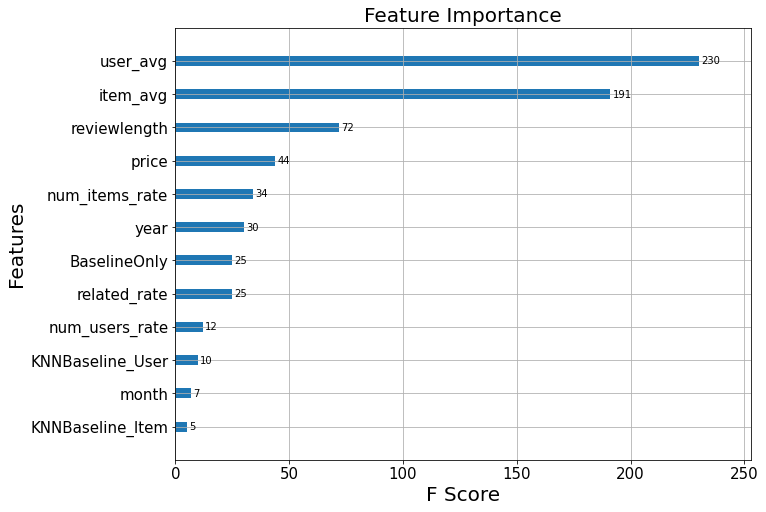

In [69]:
x_train = train_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

x_test = test_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

y_train = train_surprice.dropna().overall

y_test = test_surprice.dropna().overall

train_result, test_result, XGBBSLKNNclf = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

#### Matrix Factorization SVD

In [70]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   
#n_factors is the equivalent to dimension 'd' when matrix 'A' is broken into 'b' and 'c'. 
#So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9502663518878111
{'n_factors': 5}


In [71]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8320213052231843
MAE = 0.591675931917301
--------------------------------------------------
TEST DATA
RMSE = 0.9315579367511351
MAE = 0.6635522848796318
--------------------------------------------------
Time Taken = 0:00:02.455262


#### Matrix Factorization SVDpp with implicit feedback

In [72]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9514554485923793
{'n_factors': 10, 'lr_all': 0.006}


In [73]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7876622380510893
MAE = 0.5577581683972622
--------------------------------------------------
TEST DATA
RMSE = 0.9324745578449107
MAE = 0.6605776369866729
--------------------------------------------------
Time Taken = 0:00:15.097166


### XGBoost + Surprice BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

In [74]:
train_surprice["SVD"] = model_train_evaluation["SVD"]["Prediction"]
train_surprice["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

test_surprice["SVD"] = model_test_evaluation["SVD"]["Prediction"]
test_surprice["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [75]:
train_surprice.head()

,reviewerID,asin,overall,price,year,month,reviewlength,user_avg,item_avg,num_users_rate,num_items_rate,related_rate,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
1276,A1IT7KPZW9DY05,B00004OCMY,5.0,10.87,2006,9,153,5.000000,4.750000,32,9,4.533672,5.000000,5.0,5.000000,5.000000,5.000000
48696,A3DQ4FF1IW84EC,B0026K0XEU,5.0,19.99,2012,1,59,4.947368,4.750000,12,19,4.576923,4.620016,5.0,4.996793,4.487484,4.636682
33288,A9KAY47NCPQS,B000KIHMR6,5.0,12.99,2009,8,82,3.806452,4.083333,12,31,4.305085,4.867523,5.0,5.000000,4.739889,4.833195
28056,A2UR34OLZP2MUV,B000EGA6QI,5.0,29.95,2010,9,99,3.750000,4.503937,127,8,4.623487,4.721608,5.0,5.000000,4.523145,4.592877
251,AVR3F6VQYIMZW,B00004OCIP,5.0,8.80,2005,10,137,4.714286,4.619048,63,14,4.562676,4.827175,5.0,5.000000,4.669244,4.696699


[00:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.798640505785674
MAE = 0.538129584797179
--------------------------------------------------
TEST DATA
RMSE = 0.7963098175670011
MAE = 0.5385600906185506
--------------------------------------------------
Time Taken = 0:00:04.467558


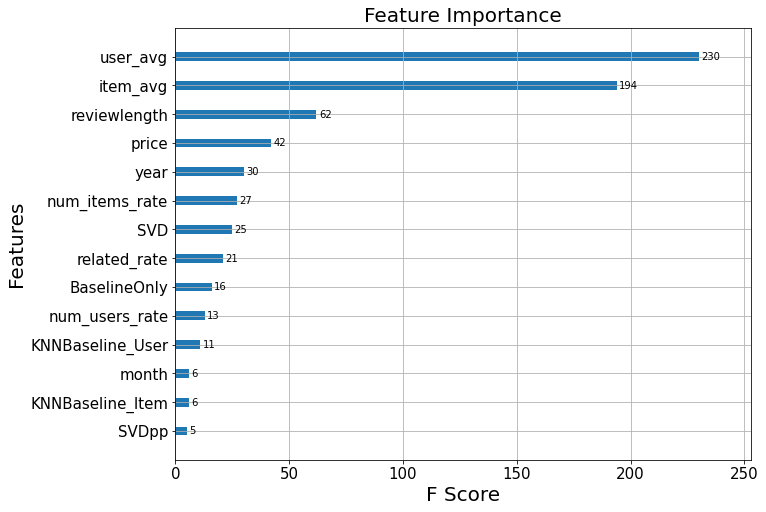

In [76]:
x_train = train_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

x_test = test_surprice.dropna().drop(["reviewerID", "asin", "overall"], axis = 1)

y_train = train_surprice.dropna().overall

y_test = test_surprice.dropna().overall

train_result, test_result, XVGBSLKNNMFclf = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

In [77]:
error_table.style.highlight_min(axis=0)

,Model,Train RMSE,Train MAE,Test RMSE,Test MAE
0,XGBoost_13,0.799155,0.537533,0.795475,0.537435
1,BaselineOnly,0.801218,0.555441,0.936638,0.650191
2,XGB_BSL,0.799023,0.537780,0.796839,0.538226
3,KNNBaseline_User,0.014901,0.004851,0.957135,0.672694
4,KNNBaseline_Item,0.014039,0.004473,0.965914,0.671247
5,XGB_BSL_KNN,0.798908,0.537481,0.795948,0.537464
6,SVD,0.832021,0.591676,0.931558,0.663552
7,SVDpp,0.787662,0.557758,0.932475,0.660578
8,XGB_BSL_KNN_MF,0.798641,0.538130,0.796310,0.538560


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


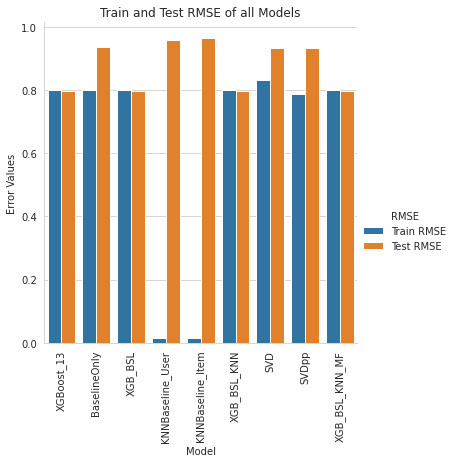

In [78]:
sns.set_style("whitegrid")
error_table_melt = error_table.drop(['Train MAE', 'Test MAE'], axis = 1).melt('Model', var_name='RMSE', value_name='vals')
sns.factorplot(x='Model', y='vals', hue='RMSE', data = error_table_melt, kind='bar')
plt.xticks(rotation=90)
plt.title("Train and Test RMSE of all Models")
plt.ylabel("Error Values")
plt.show()

The best model so far is the "XGBboost + BaselineOnly + Surprise KNN Baseline + SVD + SVDpp" model. The test RMSE is 0.81.

In [89]:
new_test = pd.DataFrame(y_test)
new_test['predicted'] = pd.DataFrame(model_test_evaluation["XGBoost_13"]["Prediction"]).values

In [90]:
new_test

,overall,predicted
12172,4.0,3.211876
47840,4.0,4.179423
18709,5.0,4.748970
60704,5.0,4.979216
72073,5.0,4.494257
...,...,...
31865,5.0,3.446652
34214,4.0,4.445910
50740,3.0,3.651484
1448,5.0,4.936572


In [91]:
new_test['predicted_rounded'] = new_test['predicted'].round(0)
new_test.head()

,overall,predicted,predicted_rounded
12172,4.0,3.211876,3.0
47840,4.0,4.179423,4.0
18709,5.0,4.748970,5.0
60704,5.0,4.979216,5.0
72073,5.0,4.494257,4.0


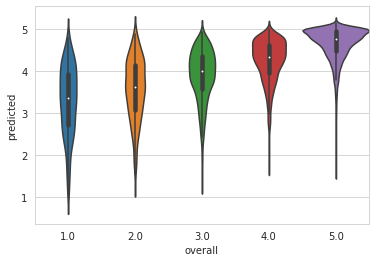

In [92]:
sns.violinplot(x='overall', y='predicted', data=new_test, width=1)

In [118]:
#Create a data frame for recommendating to a specific user chosen
complete_data = train_surprice.append(test_surprice)
def predict_for_user(user_id, clf):
  reviewed_train = train_surprice[KitchenDining['reviewerID']==user_id]
  reviewed_test = test_surprice[KitchenDining['reviewerID']==user_id]
  reviewed = reviewed_train.append(reviewed_test).drop_duplicates()
  not_reviewed = complete_data[~complete_data['reviewerID'].isin(reviewed['reviewerID'])]
  new_useravg = getAverageUserRatings(ratings_mtx_df, user_id)
  new_num_items_rate = num_items_rate(ratings_mtx_df, user_id)
  avg_reviewlength = reviewed['reviewlength'].mean()
  avg_year = reviewed['year'].mean()
  not_reviewed.loc[:,'reviewerID'] = user_id
  not_reviewed.loc[:,'user_avg'] = new_useravg
  not_reviewed.loc[:,'num_items_rate'] = new_num_items_rate
  not_reviewed.loc[:,'reviewlength'] = avg_reviewlength
  not_reviewed.loc[:,'year'] = avg_year
  combined_test = not_reviewed.append(reviewed).drop_duplicates('asin', keep='last')
  predicted = clf.predict(combined_test.drop(['reviewerID', 'asin', 'overall','BaselineOnly','KNNBaseline_User','KNNBaseline_Item','SVD','SVDpp'],axis=1))
  return predicted, combined_test

In [119]:
prediction_for_rank, data_for_pred = predict_for_user('A3LYW4IB2DAZDD', XGBclf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [120]:
data_for_pred['predicted'] = prediction_for_rank

In [124]:
top_ten = data_for_pred.sort_values('predicted', ascending=False).loc[:,['asin','predicted']][:10]
pd.merge(top_ten, KitchenDining.loc[:,['asin','title']], on='asin', how = 'left').drop_duplicates()

,asin,predicted,title
0,B005HJH2NM,4.932473,DeLonghi Red Lattissima Plus Nespresso Capsule...
12,B004YWEY8E,4.927850,Anolon Advanced Bronze Hard Anodized Nonstick ...
25,B0000Y73UQ,4.927850,Kuhn Rikon Duromatic Top Model Energy Efficien...
37,B00009ZK08,4.914598,Wusthof Classic 8-Inch Cook's Knife
54,B00FLYWNYQ,4.914598,Instant Pot IP-DUO60 7-in-1 Programmable Press...
68,B003V8A4KY,4.909204,Wusthof Classic 3-Piece Essentials Set with Ch...
79,B00015CA52,4.904581,J.K. Adams 8-Inch-by-11-1/2-Inch Sugar Maple W...
90,B00005MEGZ,4.904581,Wusthof Classic 8-Inch Bread Knife
103,B00063RWVG,4.900222,"Lodge L17SK3 Pre-Seasoned Cast Iron Skillet, 1..."
114,B004Z915M4,4.899045,"Excalibur 3900B 9 Tray Deluxe Dehydrator, Black"


In [125]:
prediction_for_rank, data_for_pred = predict_for_user('A2Z5JKDIEZF57Q', XGBclf)
data_for_pred['predicted'] = prediction_for_rank
top_ten = data_for_pred.sort_values('predicted', ascending=False).loc[:,['asin','predicted']][:10]
pd.merge(top_ten, KitchenDining.loc[:,['asin','title']], on='asin', how = 'left').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,asin,predicted,title
0,B005HJH2NM,5.000862,DeLonghi Red Lattissima Plus Nespresso Capsule...
12,B004YWEY8E,4.996239,Anolon Advanced Bronze Hard Anodized Nonstick ...
25,B0000Y73UQ,4.996239,Kuhn Rikon Duromatic Top Model Energy Efficien...
37,B004VMAC8I,4.985146,"Vitamix 1782 TurboBlend, 2-Speed"
50,B001CEPYVS,4.982747,Anolon Advanced Bronze Collection Hard Anodize...
63,B00AYCUNVU,4.982747,Circulon Symmetry Chocolate Hard Anodized Nons...
78,B00851TPAM,4.982747,Oster VERSA 1400-watt Professional Performance...
93,B000MAKVLQ,4.982747,Zojirushi NP-HBC10 5-1/2-Cup (Uncooked) Rice C...
106,B003V8A4KY,4.980407,Wusthof Classic 3-Piece Essentials Set with Ch...
117,B004Z915M4,4.979287,"Excalibur 3900B 9 Tray Deluxe Dehydrator, Black"


In [127]:
picked = KitchenDining.sample(n=1).reviewerID.values[0]
prediction_for_rank, data_for_pred = predict_for_user(picked, XGBclf)
data_for_pred['predicted'] = prediction_for_rank
top_ten = data_for_pred.sort_values('predicted', ascending=False).loc[:,['asin','predicted']].drop_duplicates()[:10]
pd.merge(top_ten, KitchenDining.loc[:,['asin','title']], on='asin', how = 'left').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,asin,predicted,title
0,B003V8A4KY,4.782069,Wusthof Classic 3-Piece Essentials Set with Ch...
11,B00063RWVG,4.775969,"Lodge L17SK3 Pre-Seasoned Cast Iron Skillet, 1..."
22,B00FLYWNYQ,4.773981,Instant Pot IP-DUO60 7-in-1 Programmable Press...
36,B000MMK448,4.773682,Baker's Edge Nonstick Edge Brownie Pan
61,B0016CBO74,4.772818,"Rattleware 58-Milimeter Round-Handled Tamper, ..."
73,B000ZUAFL4,4.770782,Norpro 3113 Cast-Aluminum Nonstick Aebleskiver...
84,B000E3DTG0,4.770782,Norpro 5569 Decorative Cup Warmer
96,B00CO5KQ4O,4.765441,Premium Tea Infuser : Tea Strainer : Tea Steep...
110,B001QXW3Q4,4.764729,"USA Pans Mini Round Cake Panel Pan, 6 Wells"
130,B00D19SSE2,4.764729,Ozeri Serafino Double Wall Insulated Beverage ...
